<a href="https://colab.research.google.com/github/Piyushbalwani/OCR/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json

In [2]:
pwd

'/content'

In [3]:
name = ""
key = ""

api_token = {"username":name,"key":key}

In [4]:
!mkdir .kaggle
!mkdir marathiocr
with open('/content/.kaggle/kaggle.json', 'w+') as file:
    json.dump(api_token, file)
import os
os.environ['KAGGLE_USERNAME'] = name
os.environ['KAGGLE_KEY'] = key

mkdir: cannot create directory ‘.kaggle’: File exists
mkdir: cannot create directory ‘marathiocr’: File exists


In [194]:
import math
import cv2
import numpy as np


def wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=0):
	"""Scale space technique for word segmentation proposed by R. Manmatha: http://ciir.cs.umass.edu/pubfiles/mm-27.pdf
	
	Args:
		img: grayscale uint8 image of the text-line to be segmented.
		kernelSize: size of filter kernel, must be an odd integer.
		sigma: standard deviation of Gaussian function used for filter kernel.
		theta: approximated width/height ratio of words, filter function is distorted by this factor.
		minArea: ignore word candidates smaller than specified area.
		
	Returns:
		List of tuples. Each tuple contains the bounding box and the image of the segmented word.
	"""

	# apply filter kernel
	kernel = createKernel(kernelSize, sigma, theta)
	imgFiltered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
	(_, imgThres) = cv2.threshold(imgFiltered, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
	imgThres = 255 - imgThres

	# find connected components. OpenCV: return type differs between OpenCV2 and 3
	if cv2.__version__.startswith('3.'):
		(_, components, _) = cv2.findContours(imgThres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	else:
		(components, _) = cv2.findContours(imgThres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

	# append components to result
	res = []
	for c in components:
		# skip small word candidates
		if cv2.contourArea(c) < minArea:
			continue
		# append bounding box and image of word to result list
		currBox = cv2.boundingRect(c) # returns (x, y, w, h)
		(x, y, w, h) = currBox
		currImg = img[y:y+h, x:x+w]
		res.append((currBox, currImg))

	# return list of words, sorted by x-coordinate
	return sorted(res, key=lambda entry:entry[0][0])


def prepareImg(img, height):
	"""convert given image to grayscale image (if needed) and resize to desired height"""
	assert img.ndim in (2, 3)
	if img.ndim == 3:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	h = img.shape[0]
	factor = height / h
	return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def createKernel(kernelSize, sigma, theta):
	"""create anisotropic filter kernel according to given parameters"""
	assert kernelSize % 2 # must be odd size
	halfSize = kernelSize // 2
	
	kernel = np.zeros([kernelSize, kernelSize])
	sigmaX = sigma
	sigmaY = sigma * theta
	
	for i in range(kernelSize):
		for j in range(kernelSize):
			x = i - halfSize
			y = j - halfSize
			
			expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
			xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
			yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)
			
			kernel[i, j] = (xTerm + yTerm) * expTerm

	kernel = kernel / np.sum(kernel)
	return kernel

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import json
import os
import re
import cv2
import h5py
import sys
import time
from IPython.display import Image
tf.__version__

'2.3.0'

In [13]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [22]:
!pip install tesseract

In [28]:
image = cv2.imread('word1.PNG')
# rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [73]:
options = "-l {}".format("mar")
text = pytesseract.image_to_string(rgb, config=options)

In [69]:
!git clone https://github.com/tesseract-ocr/tessdata

Cloning into 'tessdata'...
remote: Enumerating objects: 759, done.
remote: Total 759 (delta 0), reused 0 (delta 0), pack-reused 759
Receiving objects: 100% (759/759), 3.17 GiB | 25.66 MiB/s, done.
Resolving deltas: 100% (172/172), done.
Checking out files: 100% (172/172), done.


Image Link to detect

In [850]:
import urllib.request

impath = "https://i.pinimg.com/736x/36/8f/cb/368fcb268b2689212475aeff6c613345.jpg"
urllib.request.urlretrieve(impath, "data_img1.jpg")


('data_img1.jpg', <http.client.HTTPMessage at 0x7fee973f9358>)

In [851]:
# from google.colab import files
# uploaded = files.upload()


In [852]:
# rm data_img1.jpg

In [853]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import os
%matplotlib inline

In [854]:
filename = 'data_img1.jpg'

# Load in Grayscale
img = cv2.imread(filename)
img.shape

(1280, 720, 3)

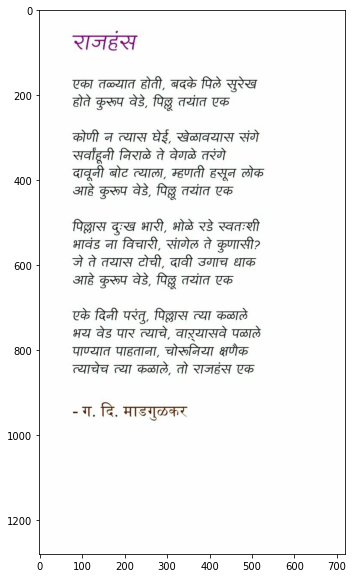

In [855]:
# print(type(img))

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

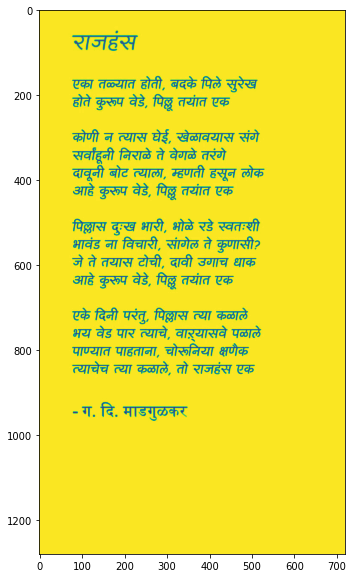

In [856]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(gray)

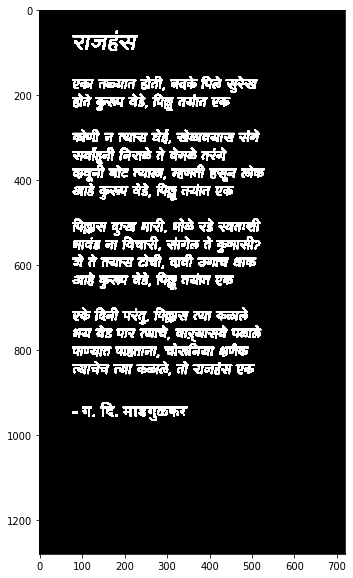

In [857]:

#binary
ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap='gray', vmax=1, vmin=0)

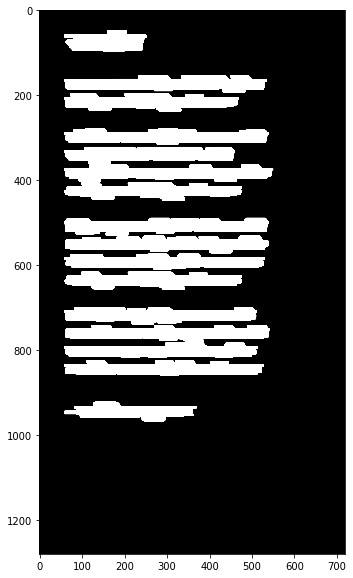

In [860]:
#dilation
kernel = np.ones((3,40), np.uint8)
img_dilation = cv2.dilate(thresh, kernel, iterations=1)
plt.figure(figsize=(10,10))
plt.imshow(img_dilation, cmap='gray', vmax=1, vmin=0)

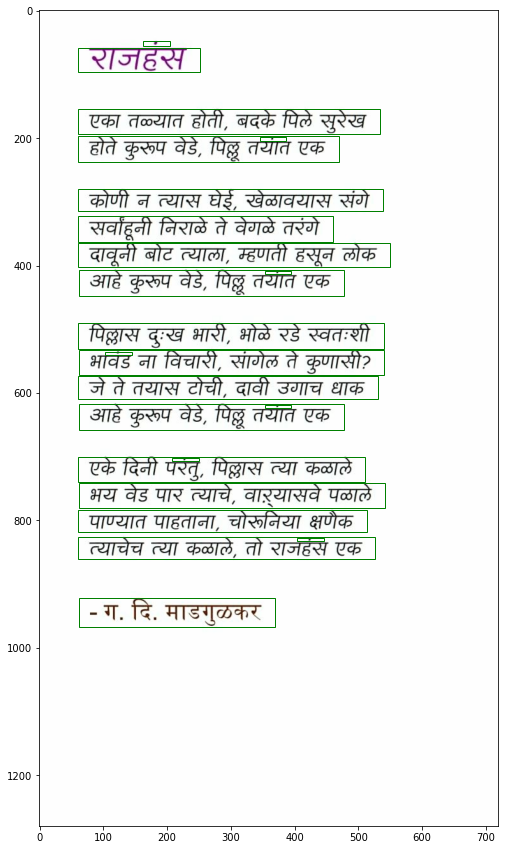

In [861]:
ctrs, hier = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#sort contours
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

plt.figure(figsize=(15,15))
current_axis = plt.gca()

lst = []

for i, ctr in enumerate(sorted_ctrs):

    sub_list = []
    # Get bounding box
    x, y, w, h = cv2.boundingRect(ctr)
    sub_list.append(y)
    sub_list.append(x)
    sub_list.append(w)
    sub_list.append(h)
    
    lst.append(sub_list)
    
    # show ROI
    current_axis.add_patch(Rectangle((x, y), w, h, edgecolor = 'g', fill=False, linewidth=1)) 

plt.imshow(img)
plt.show()

In [862]:
rm -rf data_img1/

In [863]:
os.mkdir(filename[:-4])



In [864]:
lst.sort()

# os.mkdir(filename[:-4])

for i in range(len(lst)):
      cv2.imwrite(filename[:-4] + '/' + filename[5:-4] + '-'+ str(i) + '.jpg', 
                  img[lst[i][0]: lst[i][0] + lst[i][3], lst[i][1]: lst[i][1] + lst[i][2]])

In [865]:
filename[:-4]

'data_img1'

In [866]:
# os.listdir(filename[:-4])

In [867]:
# # file = 'img1-1.jpg'
# for file in os.listdir(filename[:-4]):
#   # print(file)
#   file = os.path.join(filename[:-4],file)
#   # print(file)
#   img = cv2.imread(file)
#   plt.figure(figsize=(10,10))
#   plt.imshow(img, cmap='gray', vmax=1, vmin=0)


In [868]:
rm -rf out/

In [869]:
mkdir out

In [870]:
path1 = filename[:-4]
path2 = "out"

def segment_line():
	"""reads images from data/ and outputs the word-segmentation to out/"""

	# read input images from 'in' directory
	imgFiles = os.listdir(path1)
	for (i,f) in enumerate(imgFiles):
		print('Segmenting words of sample %s'%f)
		
		# read image, prepare it by resizing it to fixed height and converting it to grayscale
		img = prepareImg(cv2.imread(os.path.join(path1,f)), 50)
		
		# execute segmentation with given parameters
		# -kernelSize: size of filter kernel (odd integer)
		# -sigma: standard deviation of Gaussian function used for filter kernel
		# -theta: approximated width/height ratio of words, filter function is distorted by this factor
		# - minArea: ignore word candidates smaller than specified area
		res = wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=100)
		
		# write output to 'out/inputFileName' directory
		if not os.path.exists(os.path.join(path2,f)):
			os.mkdir(os.path.join(path2,f))
		
		# iterate over all segmented words
		print('Segmented into %d words'%len(res))
		for (j, w) in enumerate(res):
			(wordBox, wordImg) = w
			(x, y, w, h) = wordBox
			# print(os.path.join(path2,f,str(j)+'.png'))
			cv2.imwrite(os.path.join(path2,f,str(j)+'.png'), wordImg) # save word
			cv2.rectangle(img,(x,y),(x+w,y+h),0,1) # draw bounding box in summary image
			
		# output summary image with bounding boxes around words
		cv2.imwrite(os.path.join(path2,f,'summary.png'), img)
		

segment_line()

Segmenting words of sample img1-7.jpg
Segmented into 6 words
Segmenting words of sample img1-13.jpg
Segmented into 7 words
Segmenting words of sample img1-1.jpg
Segmented into 4 words
Segmenting words of sample img1-8.jpg
Segmented into 6 words
Segmenting words of sample img1-15.jpg
Segmented into 1 words
Segmenting words of sample img1-0.jpg
Segmented into 1 words
Segmenting words of sample img1-16.jpg
Segmented into 6 words
Segmenting words of sample img1-19.jpg
Segmented into 4 words
Segmenting words of sample img1-5.jpg
Segmented into 6 words
Segmenting words of sample img1-20.jpg
Segmented into 6 words
Segmenting words of sample img1-4.jpg
Segmented into 1 words
Segmenting words of sample img1-2.jpg
Segmented into 6 words
Segmenting words of sample img1-14.jpg
Segmented into 6 words
Segmenting words of sample img1-18.jpg
Segmented into 6 words
Segmenting words of sample img1-6.jpg
Segmented into 5 words
Segmenting words of sample img1-21.jpg
Segmented into 1 words
Segmenting words

In [871]:
# os.path.join(path1,f)

In [872]:
# for file in os.listdir(path2):
#   for file1 in os.listdir(os.path.join(path2,file)):
#     print(file1)
#     break

In [873]:
# # filename = 'out/img1-2.jpg/2.png'
# files = sorted(os.listdir(path2), key=lambda x:int(x.split('-')[1].split('.')[0]))

# for file in files:
#   print("---",file)
#   for file1 in os.listdir(os.path.join(path2,file)):
#     print(file1)
#     file1 = os.path.join(path2,file,file1)
#     img = cv2.imread(file1)
#     # plt.figure(figsize=(10,10))
#     # plt.imshow(img, cmap='gray', vmax=1, vmin=0)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


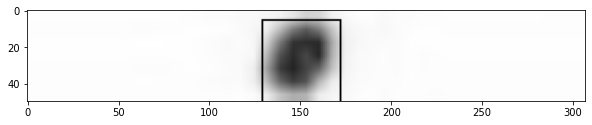

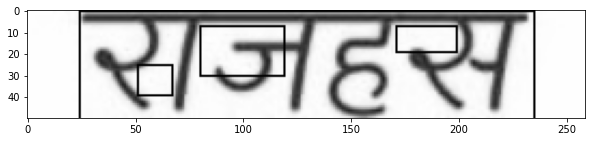

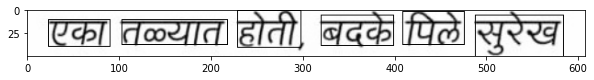

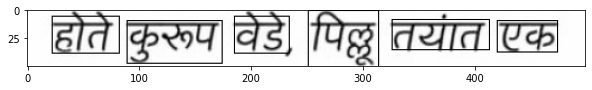

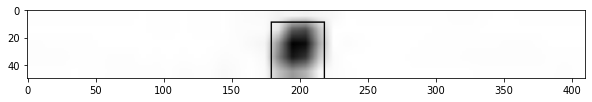

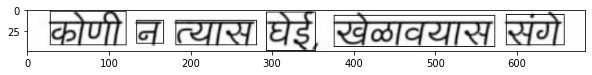

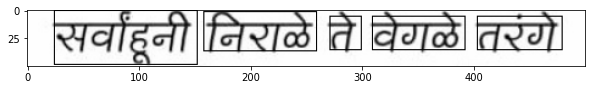

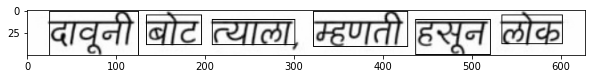

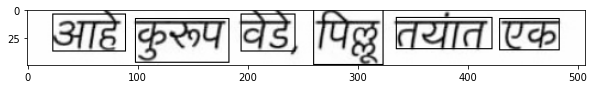

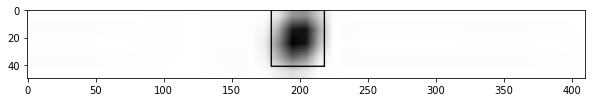

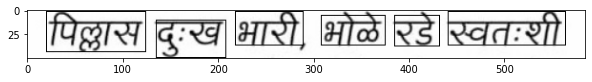

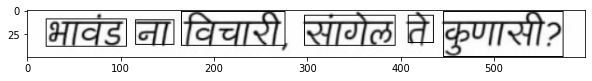

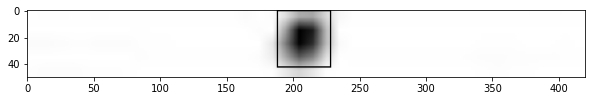

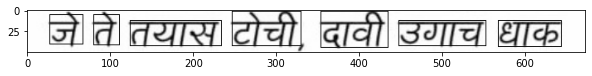

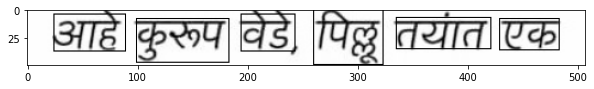

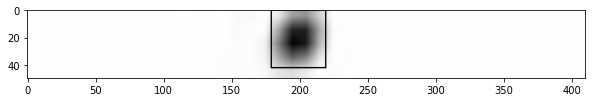

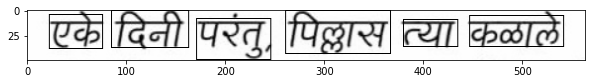

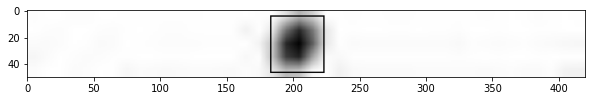

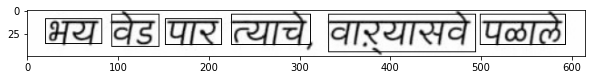

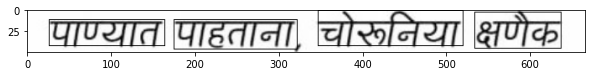

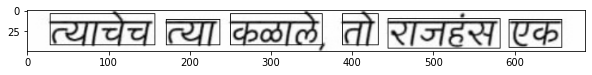

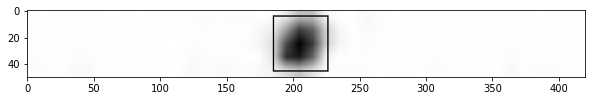

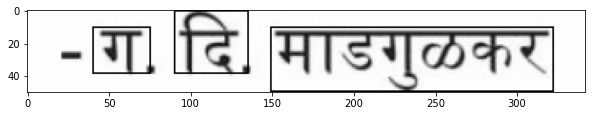

In [874]:
files = sorted(os.listdir(path2), key=lambda x:int(x.split('-')[1].split('.')[0]))
# print(files)
for file in files:
  file = os.path.join(path2,file)
  # print(file)
  # print(os.listdir(file))
  if(len(os.listdir(file)) !=0):
    img = cv2.imread(os.path.join(file,'summary.png'))
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='gray', vmax=1, vmin=0)

    # files_name = list(os.listdir(file))
    # files_name.remove('summary.png')

    # filelist = sorted(files_name, key=lambda x:int(x.split('.')[0]))
    # for file1 in filelist:
    #   # print(file)
    #   # print(file1)
    #   file1 = os.path.join(file,file1)
    #   img = cv2.imread(file1)
    #   # print(file1)

    # plt.figure(figsize=(10,10))
    # plt.imshow(img, cmap='gray', vmax=1, vmin=0)
    


 
    
     सुरंख 
 कुरूप  पिल्लु  एक 
 
कोणी      
     
 बोट    त्तोक 
   पिल्लू  एक 
 
 दुःख भारी   स्वतःशी 
     कुणासी? 
 
    दावी   
   पिल्लू  एक 
 
      
 
 वेड  त्याचे वारऱरयासवे  
   क्षणैक 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


त्याचेच     एक 
 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


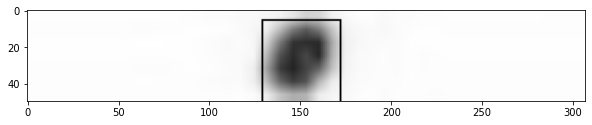

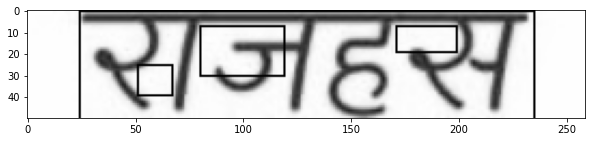

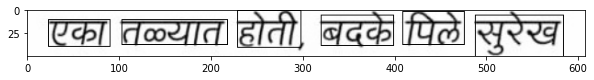

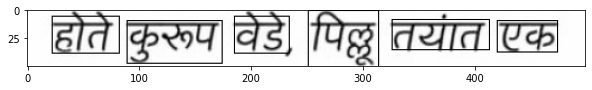

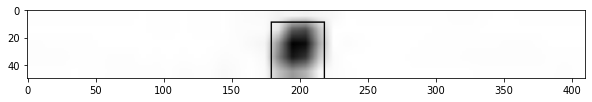

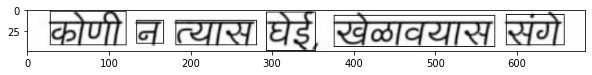

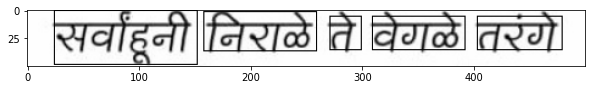

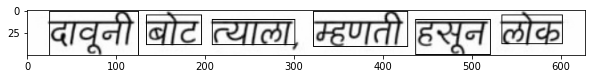

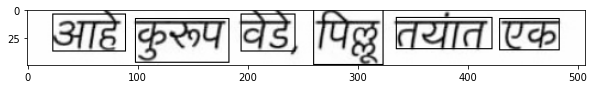

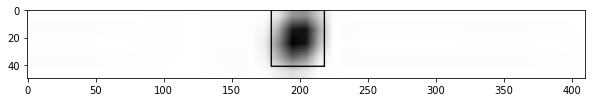

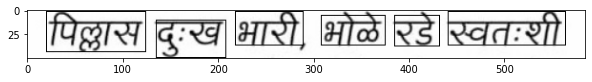

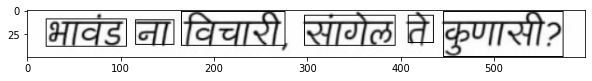

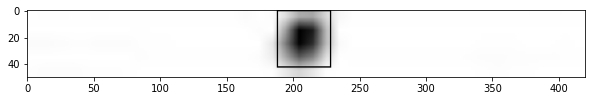

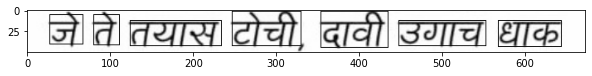

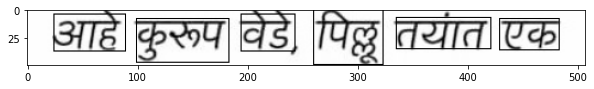

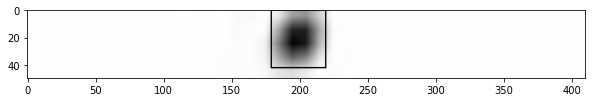

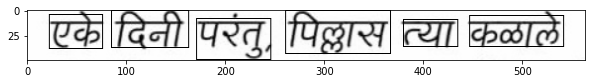

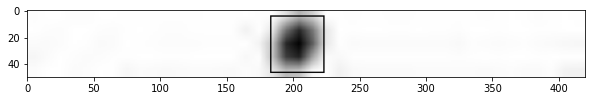

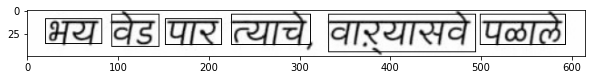

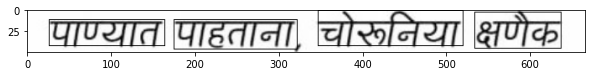

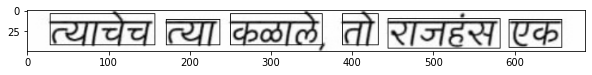

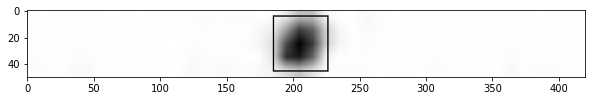

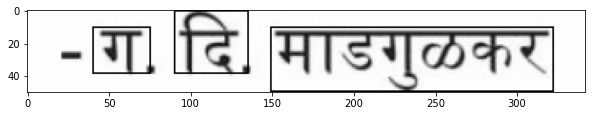

In [879]:
from PIL import Image

files = sorted(os.listdir(path2), key=lambda x:int(x.split('-')[1].split('.')[0]))
# print(files)
for file in files:
  file = os.path.join(path2,file)
  # print(file)
  # print(os.listdir(file))
  if(len(os.listdir(file)) !=0):
    # print(os.listdir(file))

    img = cv2.imread(os.path.join(file,'summary.png'))
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='gray', vmax=1, vmin=0)
    cv2.waitKey(0)
    files_name = list(os.listdir(file))
    files_name.remove('summary.png')

    filelist = sorted(files_name, key=lambda x:int(x.split('.')[0]))
    # print(filelist)
    # filelist = sorted(os.listdir(file), key=lambda x:int(x.split('.')[0]))
    str1 = ""
    for file1 in filelist:

      file1 = os.path.join(file,file1)
      # img = cv2.imread(file1)
      # print(file1)
      # print(file1)
      im=Image.open(file1)
      text=pytesseract.image_to_string(im,lang='mar')
      # print(text)
      str1 += text.strip() + ' '
  print(str1)

    


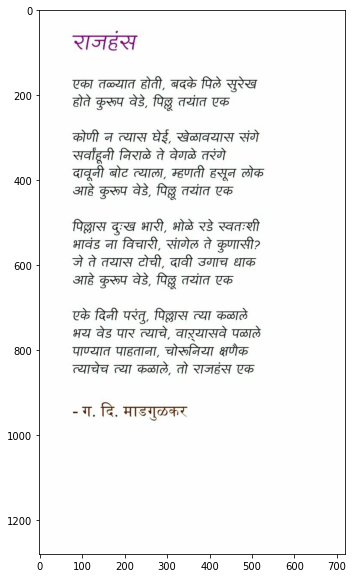

In [880]:
# print(type(img))
img = cv2.imread(filename)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [737]:
# # print(type(img))
# img = cv2.imread(filename)
# plt.figure(figsize=(10,10))
# plt.imshow(img)
# plt.show()